# General Notebook for Template Creation
------

Import the needed packages.

In [1]:
import qetpy as qp
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from rqpy import io
import rqpy as rp
import pandas as pd
from glob import glob

Specify which series we will be creating a PSD from (assuming we have beginning-of-run randoms).

In [2]:
series = '11111111_1111' # data series to pull randoms from for making the template

# set the path to the raw files to process
basepath = '/path/to/raw/data/'

# set the detector labels and corresponding channels
labels = ["Detector 1"]
channels = ["PFS1"]
det = ['Z1'] * len(channels)

fs = 625e3

In [3]:
filelist = sorted(glob(f"{basepath}{series}/*"))[:10] # first 10 dumps should have about 5000 randoms
print(f"There are {len(filelist)} files.")

There are 10 files.


Get the factor for converting from ADC bins to Amps. Also print QET bias in order to check that things make sense.

In [4]:
convtoamps = []
for ch, d in zip(channels, det):
    convtoamps.append(io.get_trace_gain(f"{basepath}{series}/", ch, d)[0])
    print(ch, io.get_trace_gain(f"{basepath}{series}/", ch, d)[-1]*1e6)

PFS1 -104.0


Open the raw data to get beginning of run randoms.

In [5]:
events, info_dict = io.get_traces_midgz(filelist, channels, det, convtoamps=convtoamps, lgcreturndict=True)

`tlen` specifies if we want to truncate the traces.

In [6]:
tlen = events.shape[-1]
nbin = events.shape[-1]
if tlen > nbin:
    tlen = nbin
print(f"tlen = {tlen} -> ~{tlen/fs*1e3:.2f} ms traces, truncated from nbin = {nbin} -> ~{nbin/fs*1e3:.2f} ms traces.")

tlen = 32768 -> ~52.43 ms traces, truncated from nbin = 32768 -> ~52.43 ms traces.


Extract the beginning-of-run randoms from the loaded traces.

In [7]:
cevent = []
for d in set(det):
    cevent.append(np.array(info_dict[f'readoutstatus{d}'])==1)

cevent = np.logical_and.reduce(cevent)
cpsd = cevent & (np.array(info_dict['triggertype'])==2)

x = events[cpsd, ..., nbin//2 - tlen//2:nbin//2 + tlen//2 + tlen%2]
print(f"There are {cpsd.sum()} randoms loaded.")

There are 3000 randoms loaded.


Make PSDs using `qetpy.autocuts`.

In [8]:
template_dict = {}
for ii, (chan, d) in enumerate(zip(channels, det)):
    print(f"Calculating PSD for channel {chan}, detector {d}")
    cut = qp.autocuts(x[:, ii], fs=fs)
    f, psd = qp.calc_psd(x[cut, ii], fs=fs, folded_over=False)
    f_fold, psd_fold = qp.foldpsd(psd, fs)
    
    template_dict[f"f_{chan}{d}"] = f
    template_dict[f"psd_{chan}{d}"] = psd
    template_dict[f"f_fold_{chan}{d}"] = f_fold
    template_dict[f"psd_fold_{chan}{d}"] = psd_fold
    print(f"The passage fraction for {chan}{d} is {cut.sum()/cpsd.sum():.3f}")    

template_dict["convtoamps"] = convtoamps

Calculating PSD for channel PFS1, detector Z1


Plot the PSDs that were calculated using `qetpy.autocuts`.

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

for ii, (chan, d) in enumerate(zip(channels, det)):
    ax.loglog(template_dict[f'f_fold_{chan}{d}'], template_dict[f'psd_fold_{chan}{d}']**0.5, 
              label=f"{labels[ii]}")
ax.legend()
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(which="minor", linestyle="dotted")
ax.grid(which="major")
ax.set_title(f"Run 51: Threshold PSDs, {series}", fontsize=14)
ax.set_ylim(1e-12, 1e-8);
ax.set_xlabel("Frequency [Hz]", fontsize=14)
ax.set_ylabel("Current PSD [A/$\sqrt{\mathrm{Hz}}$]", fontsize=14)
ax.set_xlim(6, 5.1e5)
fig.tight_layout()

In this notebook, we use `rqpy.make_ideal_template` to create the expected pulse shapes for each channel.

The pulse shapes from G147 and T5Z2 were calculated from fitting data via `qetpy.OFnonlin`. The PD2 and TES chip were determined from the theoretical TES rise and fall times. (PD2 has a phonon collection time of 20 us and an effective TES fall time of 80 us. The TES chip has an electronic rise time of about 3 us and a fall time of about 100 us.)

Note the added offset to the templates. This is because the pulses in the real data do not trigger exactly in the middle of the traces, but a little bit before the middle. Thus, we add the expected offset such that the template is placed where the expected trigger is (which if an offset of -250 for this data). This offset will likely change for each dataset!

In [10]:
risetimes = [20e-6] # rise times for each channel in s
falltimes = [69e-6] # fall times for each channel in s

for ii, (ch, d) in enumerate(zip(channels, det)):
    template_dict[f'template_{ch}{d}'] = rp.make_ideal_template(
        np.arange(events.shape[-1])/fs,
        risetimes[ii],
        falltimes[ii],
        offset=-250,
    )[nbin//2 - tlen//2:nbin//2 + tlen//2 + tlen%2]

Plot each template to make sure they are well-aligned with PD2 (our trigger channel).

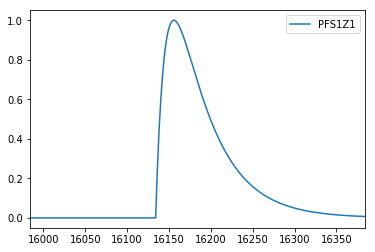

In [11]:
for ch, d in zip(channels, det):
    plt.plot(template_dict[f'template_{ch}{d}'], label=f"{ch}{d}")
plt.xlim(tlen//2 - 400, tlen//2 + 0)
plt.legend();

Save the dictionary to a specified path.

In [12]:
pathtotemplate = '/path/save/template/'

filename = f"{pathtotemplate}template_{series}"

nversions = len(glob(f"{filename}*"))+1

if nversions>0:
    filename = filename + f"_v{nversions}"
print(filename)

/path/save/template/template_11111111_1111_v1


Uncomment and run the below cell to actually save the file.

In [13]:
# with open(f"{filename}.pkl", 'wb') as f:
#     pkl.dump(template_dict, f)